# Numba
“Numba” is a combination of “NumPy” and “Mamba”. Mambas are some of the fastest snakes in the world, and Numba makes your Python code fast.

## Motivation
- It's not a magic wand that can speed up (all of your) code
- Just using the "@jit" decorator probably won't give a significant speed up
- Will probably output cryptic error message instead 

### but
- if we use datastructures with defined types (like numpy's ndarray)
- with only a little effort and using arrays it can significantly speed up code
- and even run it on the gpu or parallelize code
- create numpy like functions
- Nvidia is supporting Numba to support their Cuda toolkit

## How Numba works

- Just In Time (JIT) python compiler (compiles when function is executed)
- Compiled code can be cached (timeit!)


1) What does your code do what are the data types
- what are the other types in the function
- Analyze Python builtins and swap in their implementation
- putting in implementation llvm can compile
- Result: Intermediate representation (IR)

2) Compile into machine code
- optimization (inlining, unrolling, etc) and code generation by llvm compiler
- for different hardware
- llvm backend

3) Execute code

4) (un)boxing
- (re)boxing: put result back into python data types

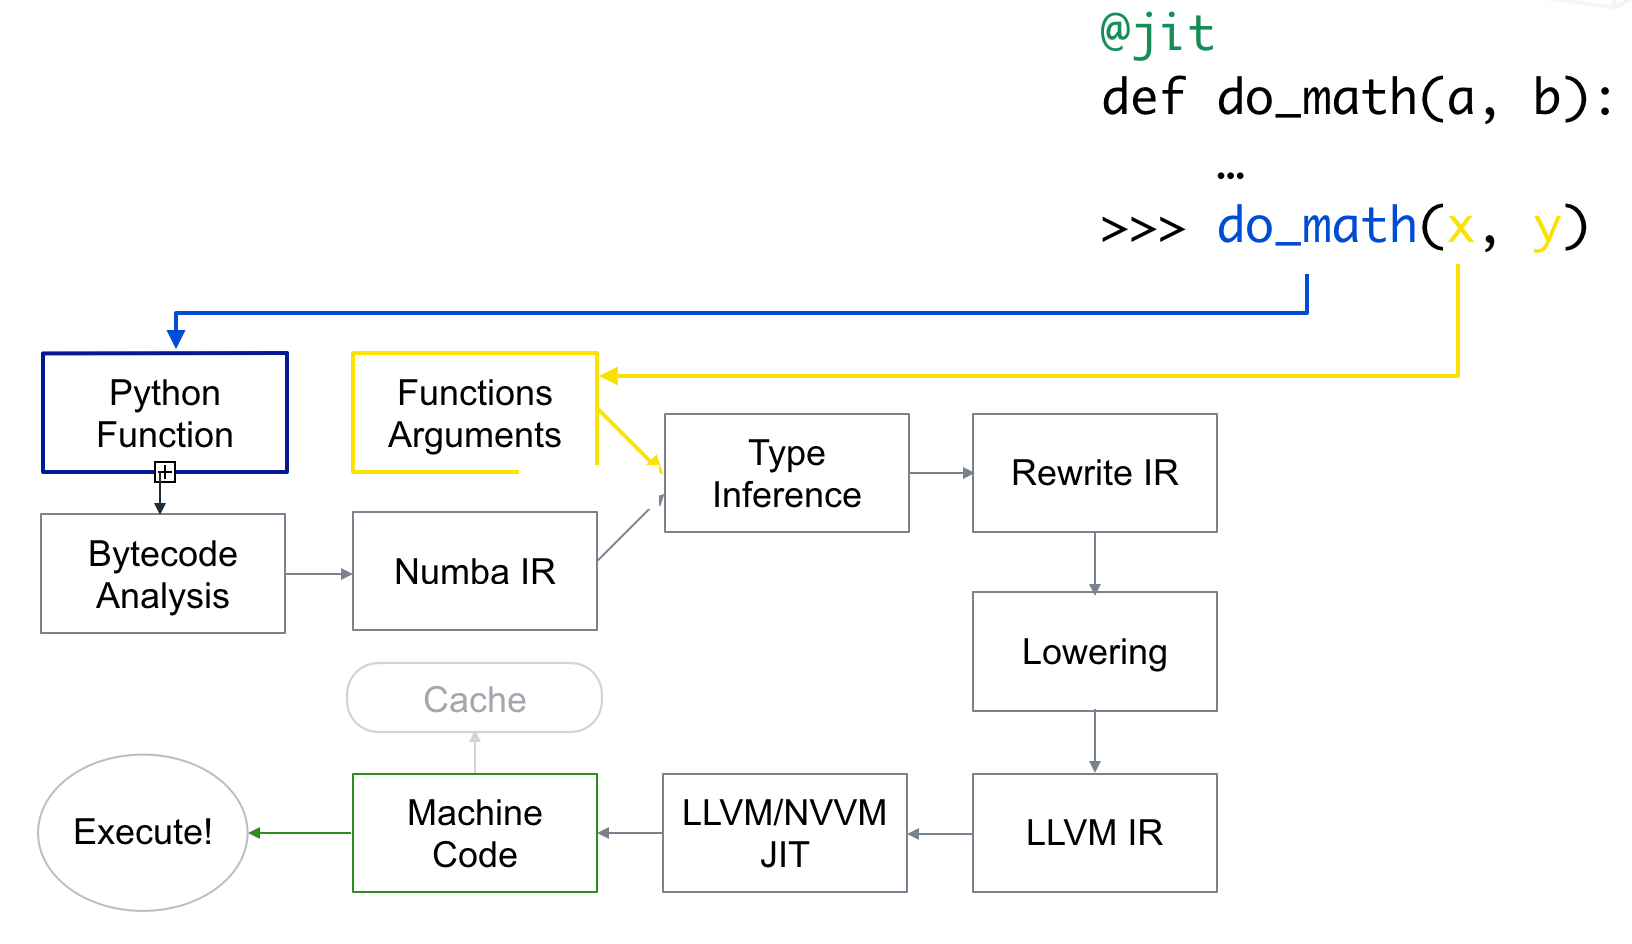


In [26]:
import numpy as np
import numba

# Using Numba
- @jit decorator (@njit short for "no Python")
- Can be used with numpy
- Good at speeding up loops
- "Python mode" tries to compile what is possible

## NumPy only

In [2]:
def numpy_only():
    a = np.random.rand(2000)
    b = np.sum(a)
    return b

%timeit numpy_only()

29.1 µs ± 1.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Numba with  numpy

In [5]:
@numba.njit
def numpy_numba():
    a = np.random.rand(2000)
    b = np.sum(a)
    return b

print(numpy_numba())
%timeit numpy_numba()

991.8680564640262
20.6 µs ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Numba, using Python loop

In [4]:
import random

@numba.njit
def loop_numba():
    a = 0.0
    for i in range(2000):
        a += random.random()
   
    return a

print(loop_numba())
%timeit loop_numba()

1004.0626403318743
18.8 µs ± 1.72 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Time python code

In [5]:
%timeit loop_numba.py_func()

232 µs ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Intermediate Representation (IR)
Assembly like representation of code

In [6]:
loop_numba.inspect_types()

# Vectorization

## ufuncs
- Known from numpy, like numpy.add(x,y)
    - operate on ndarrays
    - compiled function
    - usually C code needs to be written
- With numba we can create our own ufuncs
- and run them on the GPU
- or in parallel

### CPU

In [10]:
import numpy as np
from numba import vectorize

My_Target = 'cpu'

# @vectorize
@vectorize(['float32(float32, float32)'], target=My_Target)
def my_add_mul(x,y):    # Elementwise!
    temp = x + 0.5 * y
    if temp > 5.0:
        temp = -1.0
    return temp


x = np.arange(10, dtype=np.float32) # [0 1 2 3 4 5 6 7 8 9]
y = np.arange(10, dtype=np.float32)

print(my_add_mul(x,y))
%timeit my_add_mul(x,y)


[ 0.   1.5  3.   4.5 -1.  -1.  -1.  -1.  -1.  -1. ]
649 ns ± 44.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


### Parallel

In [11]:
import numpy as np
from numba import vectorize

My_Target = 'parallel'

@vectorize(['float32(float32, float32)'], target=My_Target)
def my_add_mul_parallel(x,y):   # Elementwise!
    temp = x + 0.5 * y
    if temp > 5.0:
        temp = -1.0
    return temp

x = np.arange(10, dtype=np.float32) # [0 1 2 3 4 5 6 7 8 9]
y = np.arange(10, dtype=np.float32)

print(my_add_mul_parallel(x,y))
%timeit my_add_mul_parallel(x,y)


[ 0.   1.5  3.   4.5 -1.  -1.  -1.  -1.  -1.  -1. ]
4.24 µs ± 1.44 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### GPU

In [6]:
import numpy as np
from numba import vectorize

My_Target = 'cuda'

@vectorize(['float32(float32, float32)'], target=My_Target)
def my_add_mul_gpu(x,y):   # Elementwise!
    temp = x + 0.5 * y
    if temp > 5.0:
        temp = -1.0
    return temp

x = np.arange(10, dtype=np.float32) # [0 1 2 3 4 5 6 7 8 9]
y = np.arange(10, dtype=np.float32)

# x_device = cuda.to_device(x)    # Not needed
# y_device = cuda.to_device(y)
# d_out = cuda.device_array_like(d_x)
# d_out.copy_to_host()

print(my_add_mul_gpu(x,y))
%timeit my_add_mul_gpu(x,y)


1.04 ms ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[ 0.   1.5  3.   4.5 -1.  -1.  -1.  -1.  -1.  -1. ]


Numba automatically:
- Compiled a CUDA kernel to execute the ufunc operation in parallel over all the input elements
- Allocated GPU memory for the inputs and the output.
- Copied the input data to the GPU
- Executed the CUDA kernel (with correct kernel dimensions)
- Copied the result back to GPU as NumPy array

# Compiling (and testing) for GPU and CPU

In [7]:
import unittest
import numpy as np

print("My_Target:", My_Target)
My_Target = "cpu"
print("Set My_Target to:", My_Target)

class TestAddMulMethod(unittest.TestCase):

    def test_my_add_mul(self):
        arr1 = np.array([-0.5, 0.0, 0.5, 1.0, 10.0], dtype=np.float32)
        arr2 = np.array([-0.3, 0.0, 0.3, 2.0, 7.0], dtype=np.float32)
        result = my_add_mul_gpu(arr1, arr2)
        np.testing.assert_array_almost_equal(result, [-0.65, 0.0, 0.65, 2.0,-1.  ])

unittest.main(argv=[''], verbosity=3, exit=False)
        

test_my_add_mul (__main__.TestAddMulMethod) ... 

My_Target: cuda
Set My_Target to: cpu


ok

----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


# Dicts and Lists
- no support for the Python dict because it is an untyped container that can have any Python types as members
- Numba has a typed dictionary
- type-inference mechanism must be able to infer the key-value types
- usable in both interpreted Python code and JIT-compiled Numba functions
- unboxing/boxing neccessary when in Python mode (stored in Numba’s native, unboxed data layout)


## Lists can be used, with some restrictions
- Only elements of same type are allowed

In [ ]:
import numpy as np
from numba import njit
from numba.core import types
from numba.typed import Dict

# @njit
@jit(nopython=False)
def main_numba_list():
    l = []                       # compiler figures out the types
    
    for i in range(10):          # creates array
        l.append(1)
        
    for i in range(10):        # mixing types gives compilation error
        l.append(np.array([1,2]))
    return l

d = main_numba_list()
print("type(d): ", type(d), d)
#%timeit main_numba_local_dict()

## Dictionaries
- Typed Dict
- Same restrictions as lists
- Currently experimental feature
- Not (yet) for GPU

### Cannot pass dictionary in @njit function
Numba has no type inforamtion

In [ ]:
import numpy as np
from numba import jit

d = {}

@jit(nopython=True)
# @jit(nopython=False)       # works, but cannot be compiled
def main_comp_error(dic):
    dic['one'] = np.array([1.0,2.0,3.0], dtype=np.float64)
    dic['two'] = np.array([2.0,3.0,4.0], dtype=np.float64)

%timeit main_comp_error(d)

### Typed Dict, Numba figures out types
If dict is created inside an @njit decoraded function Numba can infere types

In [30]:
import numpy as np
from numba import njit
from numba.core import types
from numba.typed import Dict

@njit
def main_numba_local_dict():
    dic = dict()   # numba figures out the types, dic = {} works as well
    
    for i in range(2000):
        dic[str(i)] = np.array([1.0, 2.0, 3.0], dtype=np.float64)  # d['1'] = [1.0,2.0,3.0]
    return dic

d = main_numba_local_dict()    # box
print("type(d): ", type(d))
%timeit main_numba_local_dict()

type(d):  <class 'numba.typed.typeddict.Dict'>
1.97 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Timeit, Python dict vs Numba dict

In [32]:

def main(dic):
    d = {}
    for i in range(2000):
        dic[str(i)] = np.array([1.0, 2.0, 3.0], dtype=np.float64)
    return dic

%timeit main(d)

42.6 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Numba classes

In [15]:
from numba import njit
from numba.core import types
from numba.typed import Dict
from numba.experimental import jitclass


@jitclass([                        # Inheritance?
    ("value", types.int64),
])
class Counter():
    def __init__(self):
        self.value = 0
    
    def get(self) -> int:
        self.value += 1
        return self.value
        
 
@njit
def main():
    dic = dict()
    dic['one'] = Counter()
    dic['two'] = Counter()
    return dic

dicts = main()
for d in dicts.values():
    print(d.get())


1
1


# References
[1] https://developer.nvidia.com/blog/numba-python-cuda-acceleration/

[2] https://www.youtube.com/watch?v=-4tD8kNHdXs

[3] https://numba.pydata.org/

### More Examples

In [ ]:
import numpy as np
from numba import njit
from numba.core import types
from numba.typed import Dict
from typing import List
from numba.experimental import jitclass

@jitclass([
    ("value", types.int64),
])
class Counter():
    value: int

    def __init__(self):
        self.value = 0

    def get(self) -> int:
        self.value += 1
        return self.value
        
d = dict()

d['one'] = Counter()
d['two'] = Counter()
    
for c in d.values():
    print(c.get())

### Create Typed Dict

In [ ]:
import numpy as np
from numba import njit
from numba.core import types
from numba.typed import Dict

# The Dict.empty() constructs a typed dictionary.
# The key and value typed must be explicitly declared.
d = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64[:],
)

d['one'] = np.array([1.0,2.0,3.0], dtype=np.float64)
d['two'] = np.array([2.0,3.0,4.0], dtype=np.float64)

print(d)